In [1]:
import sklearn
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import csv
from collections import namedtuple
import gensim
import matplotlib.pyplot as plt
import nltk
import sys
import numpy as np
from scipy import interp
from itertools import cycle
import seaborn as sns
import pandas as pd

## Functions for loading all of the data

In [2]:
def getData(foldername):
    # listOfFiles = os.listdir(foldername);
    data = dict()
    EachInstance = namedtuple("EachInstance", "ID gene disease sentence association")

    # for eachFile in listOfFiles:
    fileObj = open(foldername)  # +'/'+eachFile)
    csvReader = csv.reader(fileObj)
    next(csvReader)
    for row in csvReader:
        #if row[1] == 'Y' or row[1] == 'N':
        #    tempObj = EachInstance(ID=row[0], gene=row[2], disease=row[3], sentence=row[4],
        #                           association='P')
        #else:
        tempObj = EachInstance(ID=row[0], gene=row[2], disease=row[3], sentence=row[4],
                               association=row[1])
        data[row[0]] = tempObj
    fileObj.close()
    return data


def getData_directcsv(foldername):
    # listOfFiles = os.listdir(foldername);
    data = dict()
    EachInstance = namedtuple("EachInstance", "ID gene disease sentence association")

    # for eachFile in listOfFiles:
    fileObj = open(foldername)  # +'/'+eachFile)
    csvReader = csv.reader(fileObj)
    next(csvReader)
    for row in csvReader:
        #if row[1] == 'Y' or row[1] == 'N':
            #tempObj = EachInstance(ID=row[0], gene=row[2], disease=row[3], sentence=row[4],
            #                       association='P')
        #else:
        tempObj = EachInstance(ID=row[0], gene=row[2], disease=row[3], sentence=row[4],
                                association=row[1])
        data[row[0]] = tempObj
    fileObj.close()
    return data


def getTrainTest(ynData, fData):
    trainDataYN, testDataYN = train_test_split(list(ynData.values()),test_size=0.15,random_state=7)
    trainDataF, testDataF = train_test_split(list(fData.values()),test_size=0.15,random_state=7)
    trainData = trainDataYN + trainDataF
    testData = testDataYN + testDataF
    print('Train data:',len(trainData))
    print('Test data:',len(testData))
    print('Train data YN:',len(trainDataYN))
    print('Test data YN:',len(testDataYN))
    print('Train data F:',len(trainDataF))
    print('Test data F:',len(testDataF),'\n')
    # sys.exit()
    trainDataOutput = dict()
    testDataOutput = dict()
    for i in trainData:
        trainDataOutput[i.ID] = i
    for i in testData:
        testDataOutput[i.ID] = i

    return trainDataOutput, testDataOutput


def vecSum(arr1,arr2):
    new_arr = []
    for i in range(len(arr1)):
        new_arr.append(arr1[i] + arr2[i])
    return new_arr


def vecDivide(arr1,n):
    new_arr = []
    for i in range(len(arr1)):
        new_arr.append(arr1[i] / n)
    return new_arr


def wordVecFeature(model,data):
    feat = dict()
    for eachFile in data:
        eachSentence = data[eachFile].sentence
        sentEmb = []
        count = 0
        for eachWord in nltk.tokenize.word_tokenize(eachSentence):
            try:
                if len(sentEmb) == 0:
                    sentEmb = model.wv.word_vec(eachWord.lower())
                else:
                    sentEmb = vecSum(model.wv.word_vec(eachWord.lower()), sentEmb)

                count += 1
            except:
                pass
        if count == 0:
            print('No word embedding: ', eachFile)
        else:
            feat[eachFile] = vecDivide(sentEmb,count)
    print('Word2Vec feature generation done!')
    sys.stdout.flush()
    return feat


def getSyntacticParseFeatures(filename):
    fileObj = open(filename)
    csvReader = csv.reader(fileObj)
    data = dict()
    next(csvReader)
    for row in csvReader:
        data[row[0]] = [float(x) for x in row[1:]]
    fileObj.close()
    return data


def getCombinedFeatures(featArr1,featArr2):
    data = dict()
    for eachId in featArr1:
        data[eachId] = featArr1[eachId] + featArr2[eachId]
    return data


def getRuleBasedFeatures(filename):
    fileObj = open(filename)
    csvReader = csv.reader(fileObj)
    data = dict()
    for row in csvReader:
        data[row[0]] = [float(x) for x in row[1:]]
    fileObj.close()
    return data


def leftSide(syntacticFeatureFilename, ruleBasedFeatureFilename):
    ruleBasedFeatures = getRuleBasedFeatures(ruleBasedFeatureFilename)
    syntacticParseFeatures = getSyntacticParseFeatures(syntacticFeatureFilename)
    combinedFeatured = getCombinedFeatures(syntacticParseFeatures, ruleBasedFeatures)
    return combinedFeatured


def getModelInputFormat(leftSideFeats, word2VecFeats,trainTestData):
    data = []
    label = []
    for instanceId in word2VecFeats:
        featVect = word2VecFeats[instanceId] + leftSideFeats[instanceId]
        data.append(featVect)
        label.append(trainTestData[instanceId].association)
    
    return data, label

In [3]:
# Names of files used
trainFoldername = '../dataset/final_train.csv'
testFoldername = '../dataset/final_test.csv'
trainData = getData_directcsv(trainFoldername)
testData = getData_directcsv(testFoldername)
word2VecFilename = '../script_muazzam/skipGram_model.model'
syntacticFeatureFilenameTrain = '../dataset/train_original_with_id.csv'
ruleBasedFeatureFilenameTrain = '../dataset/rule_feature_train.csv'
syntacticFeatureFilenameTest = '../dataset/test_original_with_id.csv'
ruleBasedFeatureFilenameTest = '../dataset/rule_feature_test.csv'

# load Word2Vec Features
word2VecModel = gensim.models.Word2Vec.load(word2VecFilename)
#word2VecModel = gensim.models.KeyedVectors.load_word2vec_format('/home/jsilva/winFiles/Downloads/PubMed-and-PMC-w2v.bin', binary=True)
trainFeaturesWord2Vec = wordVecFeature(word2VecModel, trainData)
testFeaturesWord2Vec = wordVecFeature(word2VecModel, testData)

trainFeaturesLeftSide = leftSide(syntacticFeatureFilenameTrain, ruleBasedFeatureFilenameTrain) 
testFeaturesLeftSide = leftSide(syntacticFeatureFilenameTest, ruleBasedFeatureFilenameTest)

Word2Vec feature generation done!
Word2Vec feature generation done!


### Setting up the data to use with the classifiers

In [55]:
key = {'F':0, 'N':1, 'Y':1} # two classes
# key = {'F':0, 'N':-1, 'Y':1} # three classes

X,y = getModelInputFormat(trainFeaturesLeftSide, trainFeaturesWord2Vec, trainData)
Xtest, ytest = getModelInputFormat(testFeaturesLeftSide, testFeaturesWord2Vec,testData)
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
Xtest = scaler.transform(Xtest)
#y = [key[l] for l in y]
#ytest = [key[l] for l in ytest]

In [29]:
subset_X = [x[100:325] for x in X]
subset_Xtest = [x[100:325] for x in Xtest]
logRegModel = LogisticRegression(solver='liblinear', multi_class='auto').fit(subset_X,y)
print(precision_recall_fscore_support(ytest, logRegModel.predict(subset_Xtest), average='weighted'))
precision_recall_fscore_support(ytest, logRegModel.predict(subset_Xtest))

(0.71441873999709, 0.7189873417721518, 0.7040241137186795, None)


(array([0.54545455, 0.8045977 , 0.71969697]),
 array([0.35294118, 0.60869565, 0.89622642]),
 array([0.42857143, 0.69306931, 0.79831933]),
 array([ 68, 115, 212]))

In [35]:
#logRegModel = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='auto').fit(X,y)
logRegModel = LogisticRegression(solver='liblinear', multi_class='auto').fit(X,y)
print(precision_recall_fscore_support(ytest, logRegModel.predict(Xtest), average='weighted'))
precision_recall_fscore_support(ytest, logRegModel.predict(Xtest))

(0.7484298904668589, 0.7544303797468355, 0.7475924507724447, None)


(array([0.58823529, 0.81904762, 0.76150628]),
 array([0.44117647, 0.74782609, 0.85849057]),
 array([0.50420168, 0.78181818, 0.80709534]),
 array([ 68, 115, 212]))

In [47]:
coef = logRegModel.coef_[0]
coef = [(c, n) for c, n in zip(coef, range(len(coef)))]
print([c[1] for c in sorted(coef, key=lambda c: abs(c[0]))][-10:])

[333, 28, 72, 57, 325, 46, 43, 100, 116, 334]


## Making ROC charts

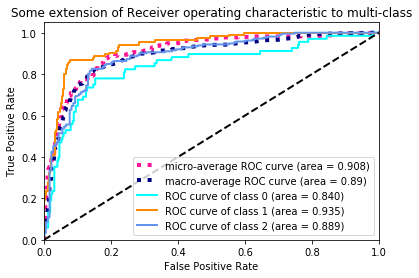

In [66]:
# Based on the scikit learn ROC page (slightly modified)
update = dict(F=[1, 0, 0], N=[0, 1, 0], Y=[0,0,1])
ytest2 = np.array([update[k] for k in ytest])
# Change the below line depending on the model of interest
yscore = gbc.predict_proba(Xtest)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ytest2[:,i], yscore[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytest2.ravel(), yscore.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 3
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [5]:
# Update the way values are stored to work with pandas/seaborn
tpr_list = []
for k in tpr.keys():
    tpr_list += [(v, k) for v in list(tpr[k])]
fpr_list = []
for k in fpr.keys():
    fpr_list += list(fpr[k])
wide_df = pd.DataFrame()
wide_df['tpr'] = [x[0] for x in tpr_list]
wide_df['set'] = [x[1] for x in tpr_list]
wide_df['fpr'] = fpr_list

def update_set(x):
    if x == 0:
        return 'F (area = 0.82)'
    if x == 1:
        return 'N (area = 0.89)'
    if x == 2:
        return 'Y (area = 0.84)'
    if x == 'micro':
        return 'micro-average (area = 0.88)'
    else:
        return 'macro-average (area = 0.85)'

wide_df['set'] = wide_df['set'].apply(update_set)

Text(0, 0.5, 'True Positive Rate')

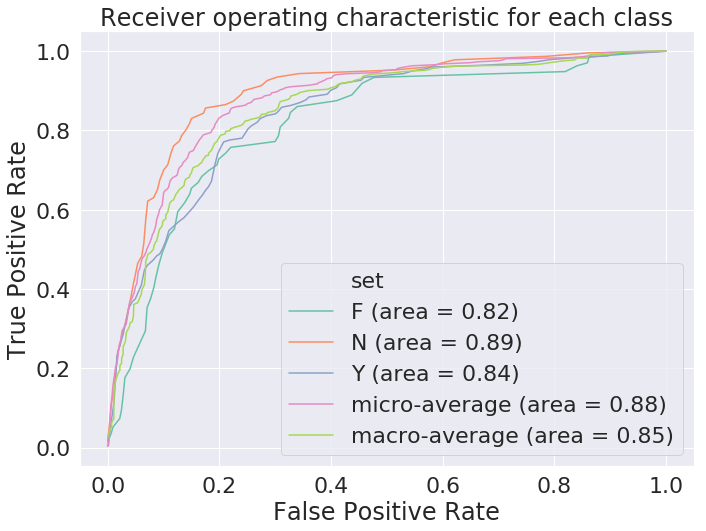

In [6]:
sns.set()
sns.set(rc={'figure.figsize':(11,8)}, font_scale=2)
ax = sns.lineplot(x='fpr', y='tpr', hue='set', palette='Set2', ci=None, data=wide_df)
ax.set_title('Receiver operating characteristic for each class')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

### Other models

In [37]:
# SVM
svm_clf = SVC(kernel='sigmoid', gamma='scale').fit(X, y)
print(precision_recall_fscore_support(ytest, svm_clf.predict(Xtest), average='weighted'))
print(sum([t == p for t, p in zip(ytest, svm_clf.predict(Xtest))])/len(ytest))
precision_recall_fscore_support(ytest, svm_clf.predict(Xtest))

(0.7421871133530028, 0.7468354430379747, 0.7286340467119624, None)
0.7468354430379747


(array([0.62857143, 0.82105263, 0.73584906]),
 array([0.32352941, 0.67826087, 0.91981132]),
 array([0.42718447, 0.74285714, 0.81761006]),
 array([ 68, 115, 212]))

In [40]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=1000, max_features=18, # make 18 if including chunk head
                                max_depth=None, min_samples_split=2).fit(X, y)

In [42]:
print(precision_recall_fscore_support(ytest, rf_clf.predict(Xtest), average='weighted'))
precision_recall_fscore_support(ytest, rf_clf.predict(Xtest))

(0.7189503104065383, 0.7240506329113924, 0.7129758645562285, None)


(array([0.48979592, 0.83516484, 0.72941176]),
 array([0.35294118, 0.66086957, 0.87735849]),
 array([0.41025641, 0.73786408, 0.79657388]),
 array([ 68, 115, 212]))

In [56]:
gbc = GradientBoostingClassifier().fit(X, y)
print(precision_recall_fscore_support(ytest, gbc.predict(Xtest), average='weighted'))
precision_recall_fscore_support(ytest, gbc.predict(Xtest))

(0.7680986674863098, 0.769620253164557, 0.762721944898276, None)


(array([0.62962963, 0.84042553, 0.77327935]),
 array([0.5       , 0.68695652, 0.9009434 ]),
 array([0.55737705, 0.75598086, 0.83224401]),
 array([ 68, 115, 212]))